#**Thai sentiment analysis about education in Thailand on Twitter.** 🙂😐☹️

# **Model & Validation process** ⚙️🔨

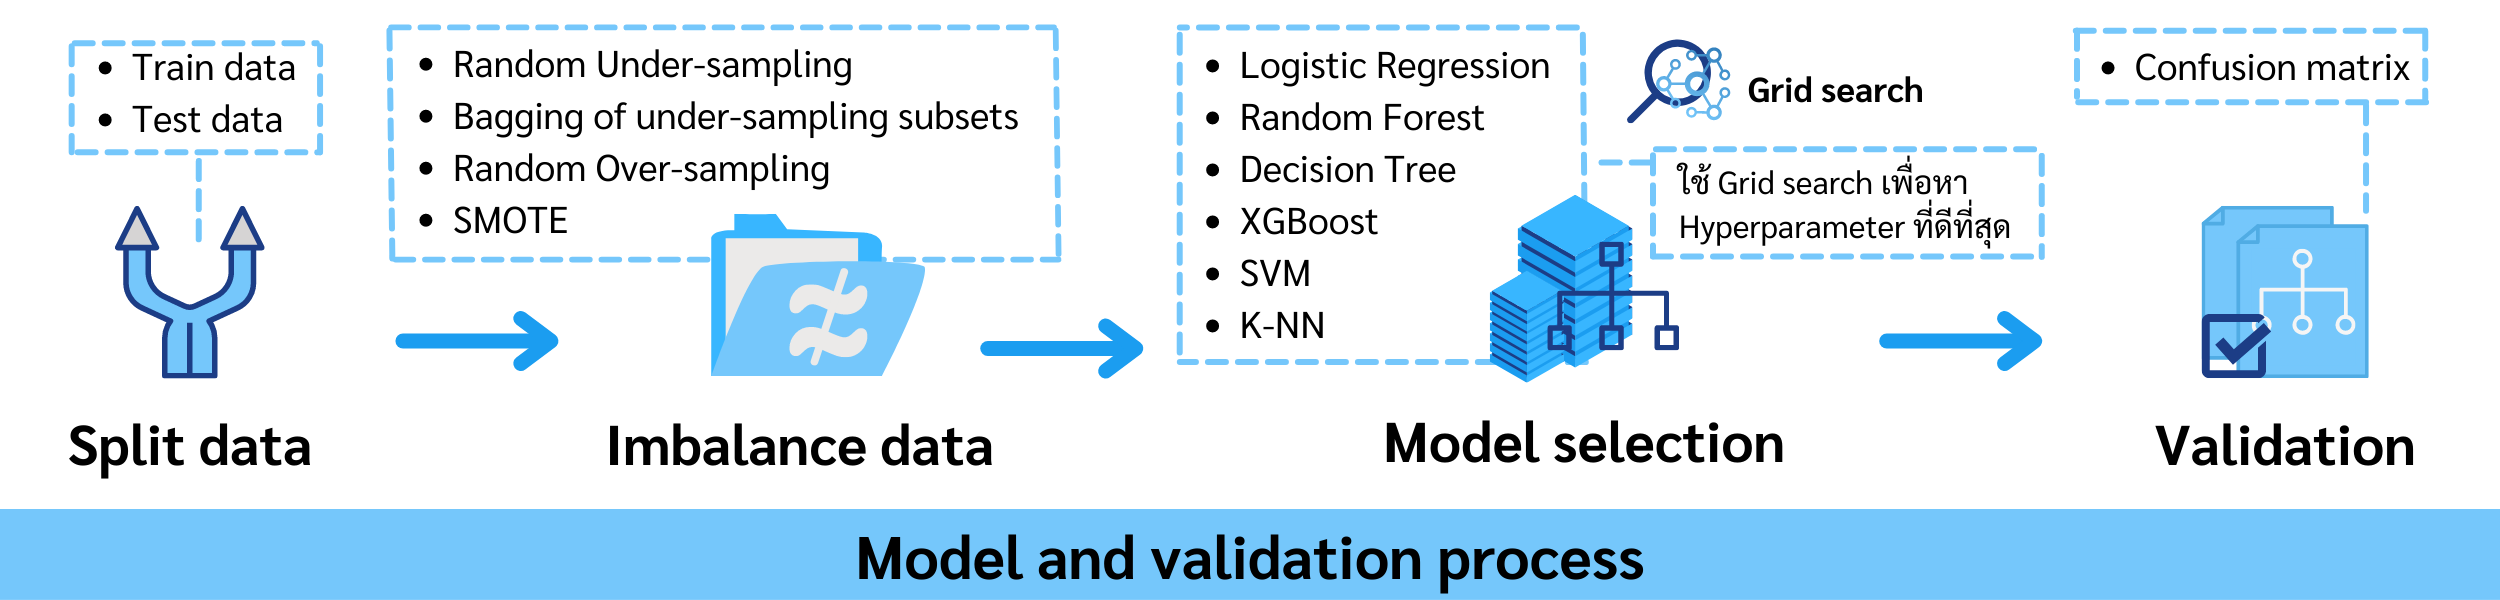


### การนำเข้าแพ็คเกจที่จำเป็น

In [ ]:
!pip install pythainlp
!pip install stop-words
!pip install stopwords
!pip install python-crfsuite

import pandas as pd
import tweepy as tw
import numpy as np 

import re
import string


import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import pickle as p
import plotly
import plotly.graph_objs as go

import urllib
import requests

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

     |████████████████████████████████| 11.5 MB 3.7 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=d8e787a4b2100e0f6a2cf9213b3441cf3e4bf24c38ec058ced20aa8c6a465040
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
     |████████████████████████████████| 965 kB 4.3 MB/s 


## Load pickle files

In [ ]:
import pickle
# load the TFIDF from disk
TFIDF = pickle.load(open('TFIDF.pkl', 'rb'))

# load the label from disk
label = pickle.load(open('label.pkl', 'rb'))

# Split data

In [ ]:
from sklearn.model_selection import train_test_split # ทำการแบ่งข้อมูลฝึกสอนและทดสอบ
x = TFIDF
y = label #train.category
# ข้อมูลฝึกสอนและทดสอบ
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4267, 1000), (4267,), (1830, 1000), (1830,))

# Imbalance data

### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler() # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [ ]:
# Class distribution
df_rus = pd.DataFrame(y_train_rus)
df_rus.value_counts()

category
-1          229
0           229
1           229
dtype: int64

# Model and validation


##Grid search    
[CS51_Grid search.ipynb]

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0, C= 2, max_iter=100, penalty= 'l2', solver= 'liblinear')

In [ ]:
Log_Reg.fit(x_train_rus, y_train_rus)

LogisticRegression(C=2, random_state=0, solver='liblinear')

In [ ]:
prediction_tfidf = Log_Reg.predict_proba(x_test)
prediction_tfidf  = np.argmax(prediction_tfidf ,axis=1)
prediction_int = prediction_tfidf -1

In [ ]:
from sklearn.metrics import f1_score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_test.apply(pd.to_numeric), prediction_int, average='weighted')

log_tfidf

0.5706451395061984

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), prediction_int))

              precision    recall  f1-score   support

          -1       0.74      0.62      0.67      1023
           0       0.52      0.42      0.47       722
           1       0.14      0.65      0.23        85

    accuracy                           0.54      1830
   macro avg       0.47      0.56      0.45      1830
weighted avg       0.63      0.54      0.57      1830



Text(23.999999999999996, 0.5, 'Actual')

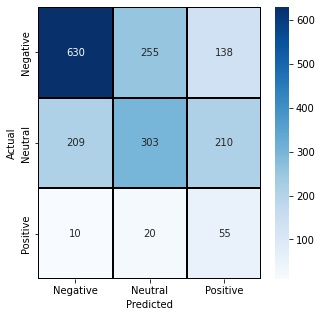

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), prediction_int)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

##XGBoost

In [2]:
from xgboost import XGBClassifier

In [ ]:
model_tfidf = XGBClassifier(random_state=29,learning_rate=0.7,colsample_bytree=1.0, gamma=2, max_depth=5,
              objective='multi:softprob', subsample=0.6)

In [ ]:
model_tfidf.fit(x_train_rus,df_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(colsample_bytree=1.0, gamma=2, learning_rate=0.7, max_depth=5,
              objective='multi:softprob', random_state=29, subsample=0.6)

In [ ]:
xgb_tfidf=model_tfidf.predict_proba(x_test)
xgb_tfidf = np.argmax(xgb_tfidf,axis=1)
xgb_tfidf = xgb_tfidf-1
xgb_tfidf 

array([ 1,  0,  0, ..., -1,  0,  1])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_test.apply(pd.to_numeric),xgb_int_tfidf, average='weighted')

score

0.5240745182325743

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), xgb_int_tfidf))

              precision    recall  f1-score   support

          -1       0.72      0.56      0.63      1023
           0       0.47      0.38      0.42       722
           1       0.10      0.54      0.17        85

    accuracy                           0.49      1830
   macro avg       0.43      0.49      0.41      1830
weighted avg       0.59      0.49      0.52      1830



Text(23.999999999999996, 0.5, 'Actual')

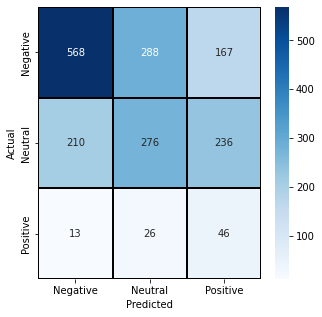

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), xgb_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=20, random_state=42)

In [ ]:
dct.fit(x_train_rus,df_rus)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=20,
                       random_state=42)

In [ ]:
dct_tfidf = dct.predict_proba(x_test)
dct_tfidf = np.argmax(dct_tfidf ,axis=1)
dct_tfidf = dct_tfidf -1
dct_tfidf

array([ 0, -1,  1, ...,  0,  1,  1])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_test.apply(pd.to_numeric),dct_int_tfidf, average='weighted')

dct_score_tfidf

0.4892960560074831

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), dct_int_tfidf))

              precision    recall  f1-score   support

          -1       0.66      0.52      0.58      1023
           0       0.46      0.36      0.40       722
           1       0.06      0.32      0.10        85

    accuracy                           0.45      1830
   macro avg       0.39      0.40      0.36      1830
weighted avg       0.55      0.45      0.49      1830



Text(23.999999999999996, 0.5, 'Actual')

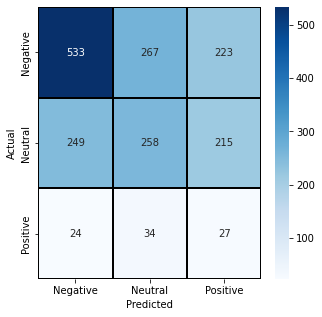

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), dct_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=6, max_leaf_nodes=5, max_samples=0.8,
                       min_samples_leaf=3,min_samples_split= 2)
text_classifier.fit(x_train_rus,df_rus)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(max_depth=6, max_leaf_nodes=5, max_samples=0.8,
                       min_samples_leaf=3, n_estimators=200, random_state=0)

###Making Predictions and Evaluating the Model
เมื่อโมเดลได้รับการฝึกอบรมแล้ว ขั้นตอนสุดท้ายคือการคาดการณ์เกี่ยวกับโมเดล ในการทำเช่นนั้น เราต้องเรียกpredictmethod บน object ของRandomForestClassifierclass ที่เราใช้ในการฝึก

In [ ]:
predictions = text_classifier.predict(x_test)

สุดท้ายในการประเมินประสิทธิภาพการทำงานของโมเดลการเรียนรู้ที่เราสามารถใช้ตัวชี้วัดการจัดหมวดหมู่เช่น Confusion Metrix ,  F1 measure, accuracy ฯลฯ
ในการค้นหาค่าของตัวชี้วัดเหล่านี้ เราสามารถใช้classification_report, confusion_matrix, และaccuracy_score utilities จาก sklearn.metricsไลบรารี

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print('Accuracy :',accuracy_score(y_test, predictions))

[[603 221 199]
 [192 246 284]
 [ 10  18  57]]
              precision    recall  f1-score   support

          -1       0.75      0.59      0.66      1023
           0       0.51      0.34      0.41       722
           1       0.11      0.67      0.18        85

    accuracy                           0.50      1830
   macro avg       0.45      0.53      0.42      1830
weighted avg       0.62      0.50      0.54      1830

Accuracy : 0.49508196721311476


Text(23.999999999999996, 0.5, 'Actual')

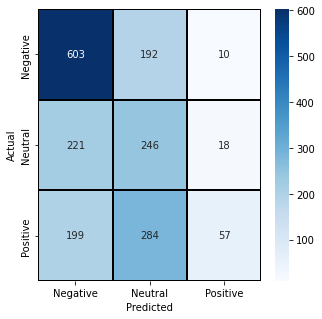

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##K-Nearest Neighbour


The gradient descent algorithm (which is used in neural network training and other machine learning algorithms) also converges faster with normalized features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(x_train_rus)

X_train = scaler.transform(x_train_rus)
X_test = scaler.transform(x_test)



###Training and Predictions
การฝึกอัลกอริทึม KNN และคาดการณ์ได้ตรงไปตรงมาอย่างยิ่ง โดยเฉพาะเมื่อใช้ Scikit-Learn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5,n_jobs=-1, weights='distance',algorithm= 'auto', leaf_size= 30, metric= 'minkowski',p= 2)
classifier.fit(x_train_rus,df_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_jobs=-1, weights='distance')

ขั้นตอนแรกคือการนำเข้าKNeighborsClassifierคลาสจากsklearn.neighborsไลบรารี n_neigboursในบรรทัดที่สองชั้นนี้จะเริ่มต้นได้ด้วยพารามิเตอร์หนึ่งคือ นี่คือค่าของ K โดยพื้นฐานแล้ว ไม่มีค่าในอุดมคติสำหรับ K และค่านี้จะถูกเลือกหลังจากการทดสอบและประเมินผล อย่างไรก็ตาม ในการเริ่มต้น ดูเหมือนว่า 5 จะเป็นค่าที่ใช้บ่อยที่สุดสำหรับอัลกอริทึม KNN

In [ ]:
y_pred = classifier.predict(X_test)

###Evaluating the Algorithm
For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[526 314 183]
 [244 278 200]
 [ 20  17  48]]
              precision    recall  f1-score   support

          -1       0.67      0.51      0.58      1023
           0       0.46      0.39      0.42       722
           1       0.11      0.56      0.19        85

    accuracy                           0.47      1830
   macro avg       0.41      0.49      0.39      1830
weighted avg       0.56      0.47      0.50      1830



ความแม่นยำโดยรวมของแบบจำลองในข้อมูลการทดสอบอยู่ที่ประมาณ 27% ซึ่งถือว่าค่อนข้างแย่เมื่อพิจารณาว่าเราไม่ได้ทำการแยกคุณลักษณะหรือประมวลผลล่วงหน้ามากนัก

Text(23.999999999999996, 0.5, 'Actual')

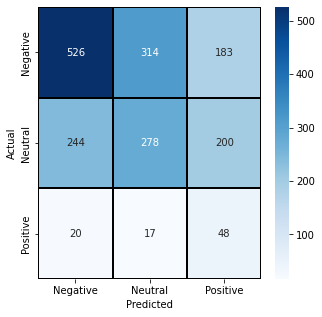

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##SVM

###Vectorizing the data

Creating a Linear SVM Model

In [ ]:
import time
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
#classifier_linear = svm.SVC(kernel='linear')


In [ ]:
# train the model on train set
#hyperparameter
#C=1, kernel='rbf', gamma=0.01
model = SVC(C=100, gamma=0.001,kernel= 'rbf')
model.fit(x_train_rus,df_rus)
 
# print prediction results
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.80      0.44      0.57      1023
           0       0.48      0.49      0.49       722
           1       0.12      0.72      0.20        85

    accuracy                           0.47      1830
   macro avg       0.46      0.55      0.42      1830
weighted avg       0.64      0.47      0.52      1830



Text(23.999999999999996, 0.5, 'Actual')

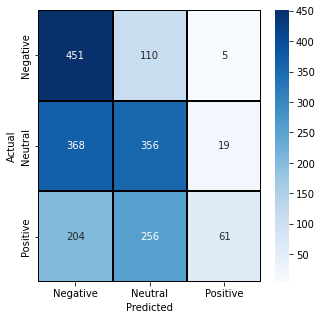

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
MNB = MultinomialNB(alpha=100, fit_prior=True, class_prior=None)
MNB.fit(x_train_rus,df_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=100)

In [ ]:
predictions = MNB.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.65      0.85      0.74      1023
           0       0.59      0.23      0.33       722
           1       0.21      0.54      0.31        85

    accuracy                           0.59      1830
   macro avg       0.48      0.54      0.46      1830
weighted avg       0.61      0.59      0.56      1830



Text(23.999999999999996, 0.5, 'Actual')

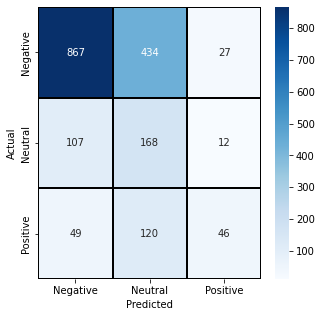

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
